In [1]:
# import torch
# import torch_directml
# device = torch_directml.device(torch_directml.default_device())
# print(f"Using DirectML device: {device}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from OverlapIndex import OverlapIndex
from iCONN_index import iCONN
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from artlib import normalize
import pickle
# import torch_directml
# device = torch_directml.device(torch_directml.default_device())

k=90
epsilon = 0.0
rho = 0.9

# ── 1) DEVICE SELECTION ───────────────────────────────────────────
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    # device = torch_directml.device(torch_directml.default_device())
print("Using device:", device)

# ── 2) SEED ───────────────────────────────────────────────────────
torch.manual_seed(0)
np.random.seed(0)

# ── 3) DATASETS & DATALOADERS ────────────────────────────────────
transform = transforms.ToTensor()
train_ds = torchvision.datasets.MNIST("./data", train=True,  download=True, transform=transform)
val_ds   = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=250, shuffle=True,
                          num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False,
                          num_workers=4, pin_memory=False)

# ── 4) LOAD FULL VALIDATION SET ONCE ─────────────────────────────
val_inputs = []
val_labels = []
for xb, yb in val_loader:
    val_inputs.append(xb)
    val_labels.append(yb)
val_inputs = torch.cat(val_inputs, dim=0).to(torch.float32).to(device)  # (10000,1,28,28)
val_labels = torch.cat(val_labels, dim=0).to(torch.long).to(device)     # (10000,)

# ── 5) STRATIFIED SUBSAMPLE FOR OI ───────────────────────────────
y_np = val_labels.cpu().numpy()
sss = StratifiedShuffleSplit(n_splits=1, train_size=1000, random_state=0)
sub_idx, _ = next(sss.split(np.zeros_like(y_np), y_np))
sub_inputs  = val_inputs[sub_idx]
sub_labels  = val_labels[sub_idx]
y_sub_np    = sub_labels.cpu().numpy()  # for OverlapIndex

# ── 6) MODEL DEFINITION ───────────────────────────────────────────
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,5,padding=2)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,5,padding=2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(32*7*7,128)
        self.fc2   = nn.Linear(128,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        z1 = self.pool1(x)           # conv1_pooled
        x = F.relu(self.conv2(z1))
        z2 = self.pool2(x)           # conv2_pooled

        flat = z2.view(z2.size(0), -1)
        z3   = F.relu(self.fc1(flat))  # fc1
        out  = self.fc2(z3)
        return out, z1, z2, z3

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ── 7) STORAGE ────────────────────────────────────────────────────
oi_conv1 = []
oi_conv2 = []
oi_fc1   = []

cn_conv1 = []
cn_conv2 = []
cn_fc1   = []
val_accuracy_history = []

# ── 8) TRAINING LOOP ─────────────────────────────────────────────
model.train()
for epoch in range(1):  # adjust epochs if needed
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x_batch, y_batch) in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # --- training step ---
        optimizer.zero_grad()
        logits, _, _, _ = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        # --- validation accuracy (every batch) ---
        model.eval()
        with torch.no_grad():
            logits_val, _, _, _ = model(val_inputs)
            preds = logits_val.argmax(dim=1)
            val_acc = (preds == val_labels).float().mean().item()
            val_accuracy_history.append(val_acc)

            # --- only every 5 batches: compute OI on subsample ---
            if batch_idx % 5 == 0:
                _, z1_sub, z2_sub, z3_sub = model(sub_inputs)
                X1 = z1_sub.view(z1_sub.size(0), -1).cpu().numpy()
                X2 = z2_sub.view(z2_sub.size(0), -1).cpu().numpy()
                X3 = z3_sub.view(z3_sub.size(0), -1).cpu().numpy()
                
                # oi1 = OverlapIndex(k=k, method="Kmeans", epsilon=epsilon)
                # oi2 = OverlapIndex(k=k, method="Kmeans", epsilon=epsilon)
                # oi3 = OverlapIndex(k=k, method="Kmeans", epsilon=epsilon)

                # cn1 = iCONN(method="Kmeans", k=k, epsilon=epsilon)
                # cn2 = iCONN(method="Kmeans", k=k, epsilon=epsilon)
                # cn3 = iCONN(method="Kmeans", k=k, epsilon=epsilon)

                oi1 = OverlapIndex(rho=rho, method="Fuzzy")
                oi2 = OverlapIndex(rho=rho, method="Fuzzy")
                oi3 = OverlapIndex(rho=rho, method="Fuzzy")

                cn1 = iCONN(rho=rho, method="Fuzzy")
                cn2 = iCONN(rho=rho, method="Fuzzy")
                cn3 = iCONN(rho=rho, method="Fuzzy")
                # prepare once per OI instance
                X1_p, _, _ = normalize(X1)
                X2_p, _, _ = normalize(X2)
                X3_p, _, _ = normalize(X3)

                oi_conv1.append(oi1.add_batch(X1_p, y_sub_np))
                oi_conv2.append(oi2.add_batch(X2_p, y_sub_np))
                oi_fc1.append(  oi3.add_batch(X3_p, y_sub_np))

                cn_conv1.append(cn1.add_batch(X1_p, y_sub_np))
                cn_conv2.append(cn2.add_batch(X2_p, y_sub_np))
                cn_fc1.append(  cn3.add_batch(X3_p, y_sub_np))

                # print(len(oi1.model.cluster_centers_))
                # print(len(oi2.model.cluster_centers_))
                # print(len(oi3.model.cluster_centers_))
                # print(len(cn1.model.cluster_centers_))
                # print(len(cn2.model.cluster_centers_))
                # print(len(cn3.model.cluster_centers_))
                # break

        model.train()
        loop.set_postfix(loss=loss.item(), val_acc=val_acc)
        

In [2]:
# ── 9) RAW VALIDATION OI ──────────────────────────────────────────
X_raw = sub_inputs.view(sub_inputs.size(0), -1).cpu().numpy()
oi_raw = OverlapIndex(k=k, method="Fuzzy", epsilon=epsilon, rho=rho)
cn_raw = iCONN(method="Fuzzy", k=k, epsilon=epsilon, rho=rho)
X_prep, _, _ = normalize(X_raw)
oi_val_raw = oi_raw.add_batch(X_prep, y_sub_np)
cn_val_raw = cn_raw.add_batch(X_prep, y_sub_np)

print("Done.")
print(f"Total batches:        {len(train_loader)}")
print(f"OI computed batches:  {len(oi_conv1)}  (≈ every 5th batch)")
print(f"Raw-val OI:           {oi_val_raw:.4f}")
print(f"Raw-val CONN:           {cn_val_raw:.4f}")

pickle.dump(
    {"oi_conv1_pooled": oi_conv1, "oi_conv2_pooled":oi_conv2, "oi_fc1":oi_fc1, "oi_raw": oi_val_raw, 
     "cn_conv1_pooled": cn_conv1, "cn_conv2_pooled":cn_conv2, "cn_fc1":cn_fc1, "cn_raw": cn_val_raw,
     "val_accuracy_history":val_accuracy_history}, 
    open("mnist_oi_kmeans.pickle", "wb")
)

Done.
Total batches:        240
OI computed batches:  48  (≈ every 5th batch)
Raw-val OI:           0.8598
Raw-val CONN:           0.0000


In [ ]:

# len(oi_raw.model.cluster_centers_)

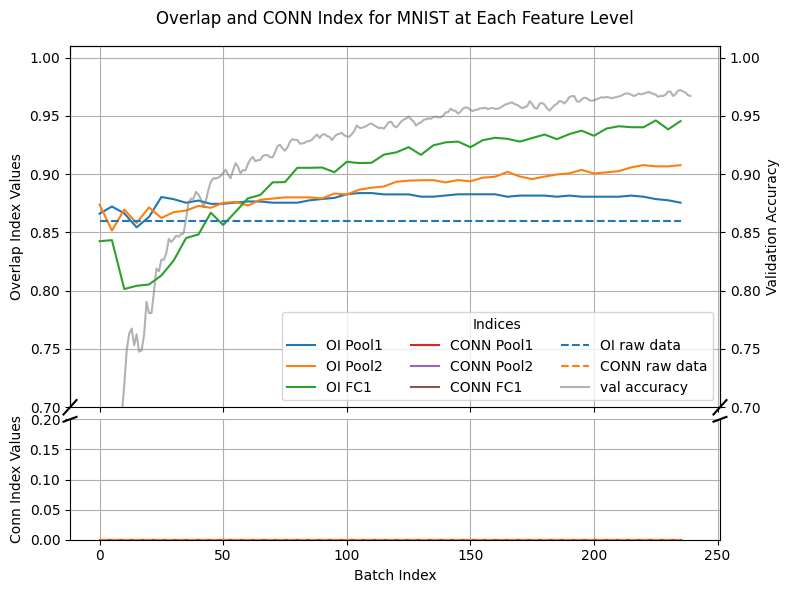

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load data
data = pickle.load(open("mnist_oi_kmeans.pickle", "rb"))
oi_conv1 = data["oi_conv1_pooled"]
cn_conv1 = data["cn_conv1_pooled"]
oi_conv2 = data["oi_conv2_pooled"]
cn_conv2 = data["cn_conv2_pooled"]
oi_fc1 = data["oi_fc1"]
cn_fc1 = data["cn_fc1"]
oi_val_raw = data["oi_raw"]
cn_val_raw = data["cn_raw"]
val_accuracy_history = data["val_accuracy_history"]

batches_oi = 5 * np.arange(len(oi_conv1))
batches_acc = np.arange(len(val_accuracy_history))

# Create broken y-axis with two subplots
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": [3, 1]}
)

# Plot same curves on both axes
for ax in (ax_top, ax_bottom):
    ax.plot(batches_oi, oi_conv1, label='OI Pool1')
    ax.plot(batches_oi, oi_conv2, label='OI Pool2')
    ax.plot(batches_oi, oi_fc1, label='OI FC1')

    ax.plot(batches_oi, cn_conv1, label='CONN Pool1')
    ax.plot(batches_oi, cn_conv2, label='CONN Pool2')
    ax.plot(batches_oi, cn_fc1, label='CONN FC1')

    ax.hlines(oi_val_raw, xmin=batches_oi[0], xmax=batches_oi[-1], linestyle='dashed', label='OI raw data', color='tab:blue')
    ax.hlines(cn_val_raw, xmin=batches_oi[0], xmax=batches_oi[-1], linestyle='dashed', label='CONN raw data', color='tab:orange')
    ax.grid(True)

# Zoom ranges
ax_top.set_ylim(0.7, 1.01)
ax_bottom.set_ylim(0.0, 0.2)

# Hide spines between axes
ax_top.spines['bottom'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_top.tick_params(labeltop=False)  # no top ticks
ax_bottom.xaxis.tick_bottom()

# Diagonal lines to indicate broken axis
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-0.01, +0.01), (-0.02, +0.02), **kwargs)
ax_top.plot((0.99, 1.01), (-0.02, +0.02), **kwargs)

kwargs.update(transform=ax_bottom.transAxes)
ax_bottom.plot((-0.01, +0.01), (1 - 0.02, 1 + 0.02), **kwargs)
ax_bottom.plot((0.99, 1.01), (1 - 0.02, 1 + 0.02), **kwargs)

# Accuracy on a secondary axis
ax_acc = ax_top.twinx()
ax_acc.plot(batches_acc, val_accuracy_history, color='gray', alpha=0.6, label='val accuracy')
ax_acc.set_ylim(0.7, 1.01)
ax_acc.set_ylabel('Validation Accuracy')

# Labeling
ax_bottom.set_xlabel("Batch Index")
ax_top.set_ylabel("Overlap Index Values")
ax_bottom.set_ylabel("Conn Index Values")
fig.suptitle('Overlap and CONN Index for MNIST at Each Feature Level')

# Legends
lines1, labels1 = ax_top.get_legend_handles_labels()
lines2, labels2 = ax_acc.get_legend_handles_labels()
ax_top.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Indices', ncol=3)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("figures/mnist_oi_accuracy_kmeans.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the CNN architecture graph
layers = [
    "Input\n1×28×28",
    "Conv1\n16 @ 5×5",
    "Pool1\n2×2 max",
    "Conv2\n32 @ 5×5",
    "Pool2\n2×2 max",
    "FC1\n128 units",
    "FC2\n10 units"
]

G = nx.DiGraph()
for i in range(len(layers) - 1):
    G.add_edge(layers[i], layers[i+1])

# Position nodes vertically
pos = {layer: (0, -i) for i, layer in enumerate(layers)}

# Plot vertically
fig, ax = plt.subplots(figsize=(2, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_shape='s',
    node_size=3000,
    font_size=10,
    arrowsize=20,
    ax=ax
)
plt.title("CNN Architecture\nfor MNIST")
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig(
    "figures/cnn_arch.png",
    bbox_inches="tight",
    pad_inches=0
)
plt.show()
